In [75]:
import os
import pandas as pd
import datetime
import calendar
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
data_dir = "/Users/Brian/Data/gdelt/raw/"
data_file = "201512_h_all_txt.zip"
freq = 'hourly'
region = 'us'

In [46]:
def get_timestamp(s):
    '''
    Translates a string that looks like "%Y-%m-%dT%H:%M:%S" and is already in gmt
    into a timestamp
    '''
    d = datetime.datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")
    return calendar.timegm(d.timetuple())

In [14]:
# This returns fast if the data is already unzipped.  
# Not sure if it will work or not when we have a different archive
# with more recent but overlapping data
current_dir = os.getcwd()
os.chdir(data_dir)
os.system("unzip " + data_dir + data_file)

256

In [90]:
g = os.walk(data_dir + 'data/' + freq + '/' + region)
g.next()
x = g.next()
count = 0
limit = 50
series = []

for triple in g:
    for filename in triple[2]:
        try:
            symbol = filename.split('.')[0]
            path = '/'.join([triple[0], filename])

            df = pd.read_csv(path)
            df['timestamp'] = (df['Date'] + 'T' + df['Time']).apply(get_timestamp)
            df = df.set_index(['timestamp'])
            df[symbol] = df.Open
            series.append(df[symbol])
        except Exception:
            # It seems that this is rare.  Not part of MVP if important at all.
            # fuck it
            pass
        count += 1
        if count >= limit:
            break;
    if count >= limit:
        break;
len(series)

50

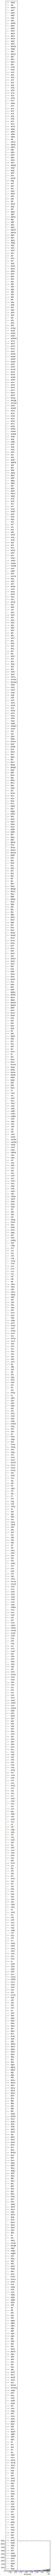

In [89]:
df = pd.DataFrame(data=series).T
df.plot()

In [69]:
filename = x[2][1]
symbol = filename.split('.')[0]
path = '/'.join([x[0], filename])

df = pd.read_csv(path)
df['timestamp'] = (df['Date'] + 'T' + df['Time']).apply(get_timestamp)
df = df.set_index(['timestamp'])
df[symbol] = df.Open
s1 = df[symbol]

In [70]:
filename = x[2][2]
symbol = filename.split('.')[0]
path = '/'.join([x[0], filename])

df = pd.read_csv(path)
df['timestamp'] = (df['Date'] + 'T' + df['Time']).apply(get_timestamp)
df = df.set_index(['timestamp'])
df[symbol] = df.Open
s2 = df[symbol]

In [66]:
s1

timestamp
1430496000    15.0700
1430499600    15.0600
1430503200    15.0690
1430510400    15.0899
1430517600    15.1499
1430755200    15.1980
1430758800    15.2900
1430762400    15.2000
1430766000    15.2000
1430769600    15.1800
1430773200    15.1800
1430776800    15.1966
1430841600    15.1700
1430845200    15.1200
1430852400    15.0775
1430856000    15.0300
1430859600    15.0000
1430863200    14.9500
1430928000    14.9500
1430938800    14.8900
1430949600    14.8100
1431014400    14.8100
1431021600    14.9100
1431032400    14.9000
1431036000    14.8895
1431100800    15.0340
1431118800    15.0900
1431122400    15.0999
1431363600    15.0923
1431367200    15.0799
               ...   
1441303200    13.1700
1442419200    13.0390
1443456000    12.5100
1443466800    12.2534
1443474000    12.1025
1443477600    12.1900
1443542400    12.0800
1443715200    12.3600
1444071600    12.8700
1444075200    12.9200
1444244400    12.9600
1444323600    12.9083
1444687200    13.0510
1444752000    13.0500


In [72]:
df = pd.DataFrame(data=[s1, s2]).T

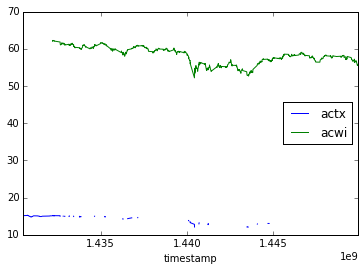

In [76]:
df.plot()